In [ ]:
#DISCLAIMER: This notebook is NOT the complete version of the project. It probably won't run properly.
#The purpose is to illustrate the data loading and training processes, as well as model structures.
#Please email me at zhiren.chen@mail.utoronto.ca if you are interested.

In [25]:
import numpy as np
import numpy.linalg as la
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import os.path
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.colors as col
import matplotlib.image as mpimg
from scipy import signal
from scipy import ndimage
from torch.autograd import Variable
import torch_dct as td
import time
plt.ion()  
randvar=0

In [53]:
sobh=torch.tensor([[[[ -1 , 0 , 1 ] ,[ -2 , 0 , 2 ] ,[ -1 , 0 , 1 ]]]]).float()
sobv=torch.tensor([[[[ -1 ,-2 , -1 ] ,[ 0 , 0 , 0 ] ,[ 1 , 2 , 1 ]]]]).float()
def showtt(tt0,fig=1,figsize=(6,6),vmax=1,vmin=0):
    tt=tt0.squeeze()
    try:
        tt=tt0.squeeze().cpu().detach().numpy()
    except:
        pass
    if fig==1:
      plt.figure(figsize=figsize)
    if tt.shape[0]==3 and not tt.shape[2]==3:
      plt.imshow(tt.transpose((1,2,0)),vmax=vmax,vmin=vmin)
    else:
      plt.imshow(tt,vmax=vmax,vmin=vmin)
def dec2uint8(img):
    return np.round(img*256).astype('uint8');
def uint82dec(img):
    return img.astype('double')/256
def batch3dgrad(img):#backpropagatable
    cnum=img.shape[1]
    hgrads=[]
    vgrads=[]
    for i in range(cnum):
      ttr=img[:,i,:,:][:,None,:,:]
      hgradr=F.conv2d(ttr, sobh, padding=1)
      vgradr=F.conv2d(ttr, sobv, padding=1)
      hgrads.append(hgradr)
      vgrads.append(vgradr)
    hgrad=torch.cat(hgrads,dim=1)
    vgrad=torch.cat(vgrads,dim=1)
    grads=torch.sqrt(torch.square(hgrad)+torch.square(vgrad))
    return grads*gradweigh
def ybatch(y, batch_size):
    """
    Generated that yields batches of data

    Args:
      y: label values
      batch_size: size of each batch
    Yields:
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(y)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_y)

In [7]:
#Data loading
dataset='dataset3/'
wd=100 #window size
gradweigh=0.2 #weigh for gradient map
strade=160 #separation between each sampling window,named 'strade' to differ from stride in models
try:
  del cleanset
  print('old trvalset deleted')
except:
  pass
labelwds={'r':[],'g':[],'b':[]}
chns=['r','g','b']
inames=os.listdir(dataset)
#inames=inames[0:1]
print(len(inames))
for i in range(len(inames)):
    img=uint82dec(io.imread(dataset+inames[i]))
    for j in range(3):
        labelwds[chns[j]]+=list(torch.tensor(img[:,:,j]).unfold(0,wd,strade).unfold(1,wd,strade).reshape(-1,wd,wd))
cleanset=[]
for i in range(len(labelwds['r'])):
    cleanset.append(np.dstack([labelwds['r'][i],labelwds['g'][i],labelwds['b'][i]]).transpose([2,0,1]))
    if i%2000==0:
      print(i)
fullsize=len(cleanset)
print(fullsize)
np.random.shuffle(cleanset)
cleanset=np.stack(cleanset).astype(np.single)

1
0
40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


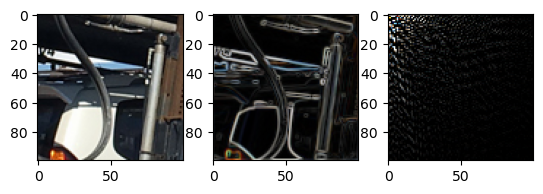

In [29]:
randex=np.random.randint(len(cleanset))
print(randex)
imt=cleanset[randex]
gr=batch3dgrad(torch.from_numpy(imt)[None,:,:,:])
plt.figure(1)
plt.subplot(1,3,1)
showtt(imt,fig=0)
plt.subplot(1,3,2)
showtt(gr,fig=0)
plt.subplot(1,3,3)
showtt(td.dct_2d(torch.from_numpy(imt)[None,:,:,:])/256,fig=0)
#left: image window, mid: gradient window, right: DCT window

5 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


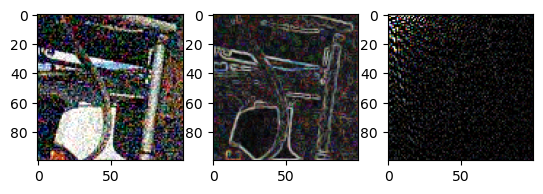

In [35]:
#real noise adder
blnset='lumixblank/'
#Folder 'lumixblank/' contains 3648*5472 images taken by the Lumix ZS110 camera at a blank wall at ISO12800
#By subtracting two such images,pure noise is obtained
#which is then randomly windowed,scaled and added to image windows
blnames=os.listdir(blnset)
blrandex1=np.random.randint(len(blnames))
blrandex2=blrandex1
while blrandex2==blrandex1:
    blrandex2=np.random.randint(len(blnames))
print(blrandex1,blrandex2)
bln1=uint82dec(io.imread(blnset+blnames[blrandex1]))
bln2=uint82dec(io.imread(blnset+blnames[blrandex2]))
blnh,blnw=bln1.shape[0:2]
def batchrealnoise(batch,strength=1,addsalt=1,nseed=randvar,blnh=3648,blnw=5472,wd=wd):
    ret=np.zeros(batch.shape)
    for i in range(batch.shape[0]):
        np.random.seed(nseed+i)
        hcor=np.random.randint(blnh-wd)
        wcor=np.random.randint(blnw-wd)
        saltnoi=np.random.normal(0, strength/10, ret.shape[2:4])
        noiwin=(bln1[hcor:hcor+wd,wcor:wcor+wd,:]-bln2[hcor:hcor+wd,wcor:wcor+wd,:]).transpose(2,0,1)
        noiwin=np.stack((noiwin[0,:,:]-np.nanmean(noiwin[0,:,:]),noiwin[1,:,:]-np.nanmean(noiwin[1,:,:]),noiwin[2,:,:]-np.nanmean(noiwin[2,:,:])))
        noicoef=(1.5*np.ones(noiwin.shape)-batch[i])/1.5
        ret[i]=batch[i]+noicoef*noiwin*strength/1.4+np.stack((saltnoi,saltnoi,saltnoi))*addsalt
    ret[ret<0]=0
    ret[ret>1]=1
    return ret
cbat=cleanset[randex:randex+1]
nbat=batchrealnoise(cbat,addsalt=1)
plt.figure(1)
plt.subplot(1,3,1)
showtt(nbat,fig=0)
plt.subplot(1,3,2)
showtt(batch3dgrad(torch.from_numpy(nbat).float()),fig=0)
plt.subplot(1,3,3)
showtt(td.dct_2d(torch.from_numpy(nbat).float())/256,fig=0)
#Similarly, the three windows after adding noise:

In [38]:
class resblock3(nn.Module): #residual block with 3 conv layers
    def __init__(self, in_chns,mid_chns, out_chns, midkernel=3, midstride=1,scale=1):#, idenmapper=None):
        super(resblock3,self).__init__()
        self.in_chns=in_chns
        self.out_chns=out_chns
        self.scalefactor=scale
        self.idenmapper=None
        midpadding= midkernel // 2
        self.conv1=nn.Conv2d(in_chns,mid_chns,kernel_size=1,stride=1,padding=0)
        self.bn1=nn.BatchNorm2d(mid_chns)
        self.conv2=nn.Conv2d(mid_chns,mid_chns,kernel_size=midkernel,stride=midstride,padding=midpadding)
        self.bn2=nn.BatchNorm2d(mid_chns)
        self.conv3=nn.Conv2d(mid_chns,out_chns,kernel_size=1,stride=1,padding=0)
        self.bn3=nn.BatchNorm2d(out_chns)
        self.act=nn.ReLU()
        if not self.in_chns==self.out_chns:
            self.idenmapper=nn.Sequential(nn.Conv2d(self.in_chns,self.out_chns,kernel_size=1),
                                    nn.BatchNorm2d(self.out_chns))
        #self.idenmapper=idenmapper
    def forward(self,x):
        #print(x.shape)
        #x=x.cuda()
        identity=x
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.act(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.act(x)
        x=self.conv3(x)
        x=self.bn3(x)
        #if self.idenmapper is not None:
        #    identity=self.idenmapper(identity)
        if not self.in_chns==self.out_chns:
            identity=self.idenmapper(identity)
        x+=identity
        x=self.act(x)
        if self.scalefactor>1:
            scaler=nn.Upsample(scale_factor=int(round(self.scalefactor)))
            x=scaler(x)
        elif self.scalefactor<1:
            scaler=nn.MaxPool2d(int(round(1/self.scalefactor)))
            x=scaler(x)
        return x
tt=torch.rand([2,4,16,16])
tblk=resblock3(4,6,10,scale=0.5)
try:
  tt=tt.cuda()
  tblk=tblk.cuda()
except:
  print('no GPU')
  pass
tpred=tblk(tt)
tpred.shape

no GPU


torch.Size([2, 10, 8, 8])

In [51]:
class imgencoder(nn.Module):
    def __init__(self, kernel, num_filters,kernel2=3, num_colours=3, num_in_channels=3):
        super(imgencoder,self).__init__()
        #resblock3d1=resblock3()
        self.downconv1 = nn.Sequential(
            resblock3(num_in_channels,num_in_channels,num_in_channels,midkernel=kernel),
            resblock3(num_in_channels,num_in_channels,num_filters,midkernel=kernel,scale=0.5),
            )
        self.downconv2 = nn.Sequential(
            resblock3(num_filters,num_filters,num_filters,midkernel=kernel2),
            resblock3(num_filters,num_filters,num_filters*2,midkernel=kernel2,scale=0.5),
            )
        self.rfconv = nn.Sequential(
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            )
        self.upconv1 = nn.Sequential(
            resblock3(num_filters*4,num_filters*2,num_filters,midkernel=3),
            resblock3(num_filters,num_filters,num_filters,midkernel=3,scale=2),
        )
        self.upconv2 = nn.Sequential(
            resblock3(num_filters*2,num_filters,num_colours,midkernel=kernel2),
            resblock3(num_colours,num_colours,num_colours,midkernel=kernel2,scale=2),)
    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        lay1 = self.downconv1(x)
        lay2 = self.downconv2(lay1)
        lay3 = self.rfconv(lay2)
        lay3=torch.cat((lay3,lay2),1)
        lay4 = self.upconv1(lay3)
        lay4=torch.cat((lay4,lay1),1)
        lay5 = self.upconv2(lay4)
        lay5=torch.cat((lay5,x),1)
        return lay5

class gradencoder(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super().__init__()

        self.downconv1 = nn.Sequential(
            resblock3(num_in_channels,num_in_channels,num_filters,midkernel=kernel,scale=0.5),
            )
        self.downconv2 = nn.Sequential(
            resblock3(num_filters,num_filters,num_filters,midkernel=3),
            resblock3(num_filters,num_filters,num_filters*2,midkernel=3,scale=0.5),
            )
        self.rfconv = nn.Sequential(
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            )
        self.upconv1 = nn.Sequential(
            resblock3(num_filters*4,num_filters*2,num_filters,midkernel=3),
            resblock3(num_filters,num_filters,num_filters,midkernel=3,scale=2),
            )
        self.upconv2 = nn.Sequential(
            resblock3(num_filters*2,num_filters,num_colours,midkernel=3,scale=2))
    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        lay1 = self.downconv1(x)
        lay2 = self.downconv2(lay1)
        lay3 = self.rfconv(lay2)
        lay3=torch.cat((lay3,lay2),1)
        lay4 = self.upconv1(lay3)
        lay4=torch.cat((lay4,lay1),1)
        lay5 = self.upconv2(lay4)
        lay5=torch.cat((lay5,x),1)
        return lay5

class dctencoder(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super().__init__()

        self.downconv1 = nn.Sequential(
            resblock3(num_in_channels,num_in_channels,num_filters,midkernel=kernel,scale=0.5),
            )
        self.downconv2 = nn.Sequential(
            resblock3(num_filters,num_filters,num_filters,midkernel=3),
            resblock3(num_filters,num_filters,num_filters*2,midkernel=3,scale=0.5),
            )
        self.rfconv = nn.Sequential(
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            resblock3(num_filters*2,num_filters*2,num_filters*2,midkernel=3),
            )
        self.upconv1 = nn.Sequential(
            resblock3(num_filters*4,num_filters*2,num_filters,midkernel=3),
            resblock3(num_filters,num_filters,num_filters,midkernel=3,scale=2),
        )
        self.upconv2 = nn.Sequential(
            resblock3(num_filters*2,num_filters,num_colours,midkernel=3,scale=2))
    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        dctx=td.dct_2d(x)
        lay1 = self.downconv1(dctx)
        lay2 = self.downconv2(lay1)
        lay3 = self.rfconv(lay2)
        lay3=torch.cat((lay3,lay2),1)
        lay4 = self.upconv1(lay3)
        lay4=torch.cat((lay4,lay1),1)
        lay5 = self.upconv2(lay4)
        lay5=torch.cat((lay5,x),1)
        return td.idct_2d(lay5)

class decoder(nn.Module):
    def __init__(self, kernel, num_colours=3):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2
        self.upconv1 = nn.Sequential(
            resblock3(num_colours*6,num_colours*6,num_colours*12,midkernel=kernel),
            resblock3(num_colours*12,num_colours*12,num_colours*12,midkernel=kernel),
            )
        self.finalconv = nn.Conv2d(num_colours*12, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        lay5 = self.upconv1(x)
        outimg = self.finalconv(lay5)
        #print(outimg)
        outgrad=batch3dgrad(outimg)
        out=torch.cat((outimg,outgrad),dim=2) #DIFFERENT FROM PREGENERATED x VERSION: NOT *gradweigh HERE
        #two constant kernel convolutions for gradients
        return out
class comnet(nn.Module):
    def __init__(self, kernel, num_filters, kernel2=3,num_colours=3, num_in_channels=3,wd=wd):
        super().__init__()
        self.wd=wd
        self.imenc=imgencoder(kernel,num_filters, kernel2=kernel2,num_colours=num_colours, num_in_channels=num_in_channels)
        self.grenc=gradencoder(kernel,num_filters, num_colours=num_colours, num_in_channels=num_in_channels)
        self.ctenc=dctencoder(kernel,num_filters, num_colours=num_colours, num_in_channels=num_in_channels)
        self.dec=decoder(kernel,num_colours=num_colours)

    def forward(self,x):
        imencout=self.imenc(x[:,:,0:self.wd,:])
        grencout=self.grenc(x[:,:,self.wd:self.wd*2,:])
        ctencout=self.ctenc(x[:,:,0:self.wd,:])
        decinp=torch.cat((imencout,grencout,ctencout),dim=1)
        decout=self.dec(decinp)
        return decout
tcomnet=comnet(5,5,kernel2=5)
cnout=tcomnet(torch.rand((4,3,wd*2,wd)).float())
cnout.shape
#The input and the output are a concatenation of the image and the gradient map at dim 2.
#The reason to design it like this is to avoid repeatly computing gradients during training.

torch.Size([4, 3, 200, 100])

In [56]:
discsize=[]
class comdisc(nn.Module): 
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()
        
        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1
        self.num_filters=num_filters
        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        self.conv1=nn.Sequential( #in=6*32*32,out=16*16*16
            nn.Conv2d(num_colours*2,num_filters,kernel_size=kernel,padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.conv2=nn.Sequential( #in=16*16*16,out=32*8*8
            nn.Conv2d(num_filters,num_filters*2,kernel_size=kernel,padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.linear1=nn.Sequential(
            nn.Linear(int(num_filters*wd*wd/8),num_filters*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.3),)
        self.linear2=nn.Sequential(
            nn.Linear(num_filters*4,1),
            nn.Sigmoid(),)
    
    def forward(self, x, img):
        global discsize
        c=torch.cat((x,img),1)
        lay1=self.conv1(c)
        lay2=self.conv2(lay1)
        lay3=lay2.view(-1,int(self.num_filters*wd*wd/8))
        lay3=self.linear1(lay3)
        out=self.linear2(lay3)
        return out
tcomdis=comdisc(5,16)
cnout=tcomdis(torch.rand((6,3,wd,wd)).float(),torch.rand((6,3,wd,wd)).float())
cnout.shape

torch.Size([6, 1])

In [59]:
#Penalty maps for DCT of output image
from skimage.transform import resize
dctpenmap=uint82dec(io.imread('UGANdctpenmap0226.jpg'))*5
dctpenmap=resize(dctpenmap,(wd,wd,3))
dctxcsmap=uint82dec(io.imread('UGANdctpenmap100b3.jpg'))*5
dctxcsmap=resize(dctxcsmap,(wd,wd,3))
dctpenmap=dctpenmap.transpose((2,0,1))
dctxcsmap=dctxcsmap.transpose((2,0,1))
print(dctpenmap.shape,dctxcsmap.shape)
try:
  dctpenmap=torch.from_numpy(dctpenmap).cuda()
  dctxcsmap=torch.from_numpy(dctxcsmap).cuda()
  weighsum=torch.sum(dctpenmap).cuda()
except:
  dctpenmap=torch.from_numpy(dctpenmap)
  dctxcsmap=torch.from_numpy(dctxcsmap)
  weighsum=torch.sum(dctpenmap)
dechroma=0 #to be overwritten when training
def dctloss(x,y,weigh=0.005):
  dctdif=torch.abs(td.dct_2d(x)-td.dct_2d(y))/256
  if dechroma==0:
    return torch.sum(torch.mul(dctdif,dctpenmap))/weighsum*weigh
  dctxcs=td.dct_2d(x)-td.dct_2d(y)
  dctxcs[dctxcs<0]=0
  dctwdef=torch.sum(torch.mul(dctdif,dctpenmap))/weighsum+torch.sum(torch.mul(dctxcs,dctxcsmap))/weighsum*dechroma
  return dctwdef*weigh

(3, 100, 100) (3, 100, 100)


In [60]:
def mse(tsa0,tsb0,gpu=1):
    tsa=tsa0
    tsb=tsb0
    if gpu:
      try:
        tsa=tsa.cuda()
        tsb=tsb.cuda()
      except:
        pass
    diff=tsa-tsb
    return torch.sum(torch.mul(diff,diff))/torch.prod(torch.tensor(tsa.shape))
tsa=torch.tensor(np.array([[[0.1,0.9,0.4],[0.8,0.2,0.5]],[[0.7,0.9,0.1],[0.2,0.7,0.3]]]))
tsb=torch.tensor(np.array([[[0.2,0.7,0.9],[0.50000,0.4,0.7]],[[0.4,0.6,0.1],[0.5,0.7,0.3]]]))
mse(tsa,tsb)
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0, figsize=[6,6],box=[],vmax=1):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  if len(box)==2:
    img_grey=img_grey[:,box[0]:box[1],:,:]
    img_real=img_real[:,box[0]:box[1],:,:]
    img_fake=img_fake[:,box[0]:box[1],:,:]
  plt.figure(figsize=figsize)
  for i in range(5):
    try:
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], vmax=vmax)
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i],vmax=vmax)
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i],vmax=vmax)
      ax.axis("off")
    except:
      pass
  plt.show()
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion,gpu=1):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if gpu:
          try:
            inputs=inputs.cuda()
            labels=labels.cuda()
          except:
            pass
        outputs = net(inputs)
        loss = criterion(outputs, labels[:,None,:,:].float())
        corr=mse(labels,outputs)
        total_err += corr
        total_loss += loss.item()
        total_epoch += len(labels) 
    err = float(total_err) / total_epoch 
    loss = float(total_loss) / (i + 1)
    return err, loss


In [61]:
import time
from torch.autograd import Variable
distlosscoef=0.1
def train_net(gen,dis,y_train_img,batchsize, learning_rate=0.01,GDratio=1, nondisamp=100, num_epochs=30,iso=12800,retain_graph=False,gpu=1,show=1,subsample=1,chpath='',saveall=0):
    global randvar
    BCE = nn.BCELoss() 
    MSE = nn.MSELoss() 
    optimizer_gen  =optim.Adam(gen.parameters(), lr=learning_rate)
    optimizer_dis = optim.Adam(dis.parameters(), lr=learning_rate/GDratio)
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    disc_loss = np.zeros(num_epochs)
    adv_loss = np.zeros(num_epochs)
    img_loss = np.zeros(num_epochs)
    dct_loss = np.zeros(num_epochs)
    grad_loss= np.zeros(num_epochs)
    # Train the network
    start_time = time.time()
    epochcount=0
    minloss=99
    lastloss=99
    for epoch in range(num_epochs):  
        total_train_loss = 0.0
        total_disc_loss = 0.0
        total_adv_loss = 0.0
        total_img_loss = 0.0
        total_dct_loss = 0.0
        total_grad_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        gen.train()
        dis.train()
        epochcount+=1
        i=0
        for (ys) in ybatch(y_train_img[torch.randperm(y_train_img.shape[0])[0:int(round(subsample*y_train_img.shape[0]))],:,:,:], batchsize):
            if randvar>999999:
                randvar=epochcount
            randvar+=1
            np.random.seed(epochcount*i*randvar)
            noi=np.random.randint(100)/1000+0.1
            xs=batchrealnoise(ys,noi*6*iso/12800,nseed=epochcount*i*randvar*2)
            if gpu:
              try:
                xs=torch.from_numpy(xs).float().cuda()
                ys=torch.from_numpy(ys).float().cuda()
              except:
                xs=torch.from_numpy(xs).float()
                ys=torch.from_numpy(ys).float()
            xgrads=batch3dgrad(xs)
            inputs=Variable(torch.nan_to_num(torch.cat((xs,xgrads),2)))
            ygrads=batch3dgrad(ys)
            labels=Variable(torch.nan_to_num(torch.cat((ys,ygrads),2)))
            # Zero the parameter gradients
            optimizer_dis.zero_grad()
            # train discriminator with real labels
            d_real=dis(labels[:,:,0:wd,:],inputs[:,:,0:wd,:])
            real_labels=Variable(torch.zeros((ys.shape[0],1)).float())
            try:
              real_labels=real_labels.cuda()
            except:
              pass
            d_loss_real=BCE(d_real,real_labels)
            #train discriminator with fake generator outputs
            img_fake=gen(inputs)
            d_fake=dis(img_fake[:,:,0:wd,:],inputs[:,:,0:wd,:]) #generated vs noisy input
            fake_labels=Variable(torch.ones((ys.shape[0],1)).float())
            try:
              fake_labels=fake_labels.cuda()
            except:
              pass
            d_loss_fake=BCE(d_fake,fake_labels)
            #train discriminator with noisy windows
            img_same=inputs[:,:,0:wd,:]
            d_same=dis(img_same,inputs[:,:,0:wd,:])
            same_labels=torch.ones((img_same.shape[0],1)).float()
            try:
              same_labels=same_labels.cuda()
            except:
              pass
            d_loss_same=BCE(d_same,same_labels)
            d_loss=d_loss_real+d_loss_fake+d_loss_same
            d_loss.backward()
            optimizer_dis.step()
            #train generator
            optimizer_gen.zero_grad()
            img_gen=gen(inputs)
            gen_labels=dis(img_gen[:,:,0:wd,:],inputs[:,:,0:wd,:]) #generated vs noisy input
            actual_labels=Variable(torch.zeros((ys.shape[0],1)).float())
            try:
              actual_labels=actual_labels.cuda()
            except:
              pass
            g_loss=BCE(gen_labels,actual_labels)
            ctloss=dctloss(img_gen[:,:,0:wd,:],labels[:,:,0:wd,:],dctlossweigh)
            imloss=MSE(img_gen,labels)
            grloss=MSE(batch3dgrad(img_gen),batch3dgrad(labels))
            genloss=g_loss+(ctloss+imloss+grloss)*nondisamp
            genloss.backward()
            optimizer_gen.step()
            # Calculate the statistics
            outputs=img_gen
            corr=mse(labels,outputs)
            total_train_err += corr
            total_train_loss += genloss.item()
            total_disc_loss += d_loss.item()
            total_adv_loss += g_loss.item()
            total_img_loss+=imloss.item()
            total_dct_loss+=ctloss.item()
            total_grad_loss+=grloss.item()
            total_epoch += len(labels)
            i+=1
            if i%200==0:
                print('batch'+str(i))
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        disc_loss[epoch] = float(total_disc_loss) / (i+1)
        adv_loss[epoch] = float(total_adv_loss) / (i+1)
        img_loss[epoch] = float(total_img_loss) / (i+1)
        dct_loss[epoch] = float(total_dct_loss) / (i+1)
        grad_loss[epoch] = float(total_grad_loss) / (i+1)
        print(("Epoch {}: Train err: {}, Train loss: {}, discrimer loss: {},\nadverserial:{},img:{},dct:{},grad:{}|").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   disc_loss[epoch],
                   adv_loss[epoch],
                   img_loss[epoch],
                   dct_loss[epoch],
                   grad_loss[epoch]
                   ))
        # Save the current model (checkpoint) to a file
        if saveall:
          torch.save({
              'gen_state_dict': gen.state_dict(),
              'dis_state_dict': dis.state_dict(),
              'loss': img_loss[epoch],
              }, chpath+'ep'+str(epochcount))
          minloss=train_loss[epoch]-adv_loss[epoch]
          print('checkpoint saved')
        elif not chpath=='' and train_loss[epoch]-adv_loss[epoch]<minloss:
          torch.save({
              'gen_state_dict': gen.state_dict(),
              'dis_state_dict': dis.state_dict(),
              'loss': img_loss[epoch],
              'gradweigh':gradweigh,
              'dctlossweigh':dctlossweigh,
              'dechroma':dechroma,
              'GDratio':GDratio,
              'nonadvamp':nondisamp,
              'iso':iso,
              }, chpath)
          minloss=train_loss[epoch]-adv_loss[epoch]
          print('checkpoint saved')
        if show:
          visual(inputs, labels, outputs, gpu, 1,box=(0,wd),figsize=[12,8])
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    epochs = np.arange(1, num_epochs + 1) 

In [63]:
gen=comnet(9,32,kernel2=5).float().cuda()
dis=comdisc(3,8).float().cuda()

In [ ]:
#Hyperparameters only for demonstration, NOT GUARANTEED TO WORK
sobh=sobh.cuda()
sobv=sobv.cuda()
gradweigh=1
dctlossweigh=1
dechroma=1
randvar=np.random.randint(50)
train_net(gen,dis,cleanset,1, learning_rate=1,GDratio=1,nondisamp=1, num_epochs=1,show=1,subsample=1,iso=8000,saveall=1,\
          chpath='')